<a href="https://colab.research.google.com/github/PaulRF93/SVM/blob/main/TESIS_TD1_4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
# Importacion de las librearias a utilizar
import io 
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import svm#, datasets
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from google.colab import files 

# Proceso para cargar la base de datos en google COLAB
base_datos = files.upload()
datos_csv = pd.read_csv(io.BytesIO(base_datos['DATOS.csv']), sep=';')
datos = np.array(datos_csv)

Saving DATOS.csv to DATOS (3).csv


In [116]:
#Valores Normalizados de cada Gas
                       #['H2' , 'CH4', 'C2H6', 'C2H4', 'C2H2',  'CO',  'CO2'], 
n_state_90 = np.array([ [ 80,    90,     90,     50,       1],
                        [ 40,    20,     15,     50,       2] ])

##Matriz de gases y diagnosticos
data_nan = datos[:,0:8]       #Matriz de gases
data_0 = data_nan[~(np.isnan(data_nan))] #Depuracion de datos faltantes
data_n_c = int(np.array(np.shape(data_nan))[1])
data_gas = np.array(data_0).reshape(int(data_0.size/data_n_c),data_n_c)

#Numero de datos
n_data = np.array(list(range(1, data_gas[:,0].size+1, 
                             1))).reshape(data_gas[:,0].size,1)

#Separacion de datos con falla y en estado normal
data = np.concatenate((n_data, data_gas), axis=1)
data_faulty_T = np.any(data_gas[:,0:5] > n_state_90[0,:], axis = 1)

#Matriz de datos con fallas
data_faulty = data[data_faulty_T, :]

#Matriz de datos en estado normal
data_normal = data[~data_faulty_T, :]

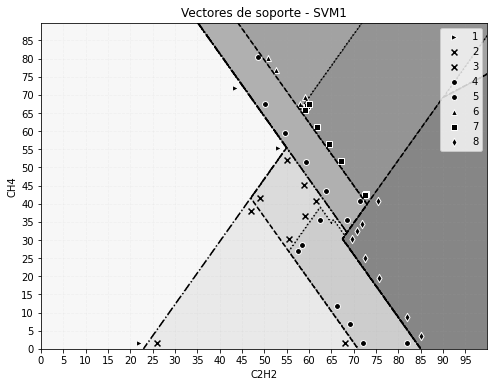

In [117]:
# Matriz de conversion
A00 = 1 # 1 para escala de 100 %
A01 = A00*math.cos(math.radians(60))
A02 = 0 # Desplazamiento en X
A10 = 0 
A11 = A00*math.sin(math.radians(60))
A12 = 0 # Desplazamiento en Y
A = np.array([[A00, A01, A02], [A10,A11, A12], [0, 0, 1]])

# Seleccion y procesamiento de datos para el entrenamiento de SVM1
TD1y_train = datos[:,11] #Estado real del equipo
TD1x = datos[:, 8:10]    #Porcentaje de C2H4 y CH4
TD1_train_ones = np.ones(TD1y_train.size).reshape(TD1y_train.size,1)
TD1x_train_f = np.concatenate((TD1x, TD1_train_ones), axis=1)
#Matriz de C2H4 Y CH4 con coordenadas rectangulares para entrenamiento
TD1x_train = np.delete(TD1x_train_f @ np.transpose(A), 2, 1)

# Seleccion y procesamiento de datos para la validacion de SVM1
TD1y_nan = data_faulty[:,6]       #Estado real del equipo
TD1y_test = TD1y_nan[~(np.isnan(TD1y_nan))] #Depuracion de datos faltantes
TDy_test = TD1y_test.reshape(TD1y_test.size,1)

MC2H4_nan = data_faulty[:,4:5]       #Matriz de C2H4
MC2H4 = MC2H4_nan[~(np.isnan(MC2H4_nan))] #Depuracion de datos faltantes
C2H4 = MC2H4.reshape(MC2H4.size,1)

MCH4_nan = data_faulty[:,2:3]       #Matriz de CH4
MCH4 = MCH4_nan[~(np.isnan(MCH4_nan))] #Depuracion de datos faltantes
CH4 = MCH4.reshape(MCH4.size,1)

MC2H2_nan = data_faulty[:,5:6]       #Matriz de C2H2
MC2H2 = MC2H2_nan[~(np.isnan(MC2H2_nan))] #Depuracion de datos faltantes
C2H2 = MC2H2.reshape(MC2H2.size,1)

#Calculo de porcentajes para C2H4, CH4 y C2H2
pC2H4 = np.round( (C2H4 / (C2H4+CH4+C2H2) )*100, decimals=3)
pCH4  = np.round( (CH4  / (C2H4+CH4+C2H2) )*100, decimals=3)
pC2H2 = np.round( (C2H2 / (C2H4+CH4+C2H2) )*100, decimals=3)
pC2H2_ones = np.ones(pC2H2.size).reshape(pC2H2.size,1)

#Matriz de porcentajes de pruebas para TD1
pMTD1 = np.concatenate((pC2H4, pCH4, pC2H2_ones), axis=1)

#Matriz de C2H4 Y CH4 con coordenadas rectangulares para validacion
TD1x_test = np.delete(pMTD1 @ np.transpose(A), 2, 1)

#Matriz para los puntos del TD1
TD1_p = np.array([
    [0, 0, 1],          #0-p1
    [0, 100, 1],        #1-p2
    [100, 0, 1],        #2-p3
    [0, 87, 1],         #3-p4
    [0, 96, 1],         #4-p5
    [0, 98, 1],         #5-p6
    [2, 98, 1],         #6-p7
    [23, 0, 1],         #7-p8
    [23, 64, 1],        #8-p9
    [20, 76, 1],        #9-p10
    [20, 80, 1],        #10-p11
    [40, 31, 1],        #11-p12
    [40, 47, 1],        #12-p13
    [50, 35, 1],        #13-p14
    [50, 46, 1],        #14-p15
    [50, 50, 1],        #15-p16
    [71, 0, 1],         #16-p17
    [85, 0, 1]])        #17-p18

# Transformacion de las cordenadas TD1 en rectangulares
TD1_v = TD1_p @ np.transpose(A)
# Se define las regiones en funcion de los puntos de cada area del TD1
region_PD_1 = TD1_v[[5, 1, 6], :]
region_T1_1 = TD1_v[[4, 5, 6, 10, 9], :]
region_T2_1 = TD1_v[[9, 10, 15, 14], :]
region_T3_1 = TD1_v[[13, 15, 2, 17], :]
region_D1_1 = TD1_v[[0, 3, 8, 7], :]
region_D2_1 = TD1_v[[7, 8, 12, 11, 16], :]
region_DT_1 = TD1_v[[3, 4, 14, 13, 17, 16, 11, 12], :]

#Parametros de regulacion para SVM1
C_1 = 1 #Regulacion 1 - valor 1
clf_1 = svm.SVC(kernel='linear', C = C_1, decision_function_shape='ovo')
modelo_SVM1 = clf_1.fit(TD1x_train,TD1y_train)
h = 0.1 #Regulacion 2 - valor 0.1
TD1_xx, TD1_yy = np.meshgrid(np.arange(0, 100, h), 
                             np.arange(0, 90, h))
TD1_z = clf_1.predict(np.c_[TD1_xx.ravel(), 
                            TD1_yy.ravel()]).reshape(TD1_xx.shape)

#Grafica de vectores de soporte SVM1 y Areas
alfa_TD1 = 0.1
plt.figure(figsize=(8, 6))
plt.contourf(TD1_xx, TD1_yy, TD1_z, 8, cmap = 'binary', alpha = 0.5)
plt.grid(linestyle = '--', alpha = 0.1, axis = 'both')
plt.xlim(TD1_xx.min(), TD1_xx.max())
plt.ylim(TD1_yy.min(), TD1_yy.max())
plt.title('Vectores de soporte - SVM1')
plt.xlabel("C2H2")
plt.ylabel("CH4")
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 90, 5))

  #Grafica de los limites entre vectores de soporte
plt.contour(TD1_xx, TD1_yy, TD1_z,
            linestyles = ['-.','--',':','-.','--',':','--'],
            colors = 'k', 
            levels = [1,2,3,4,5,6,7,8])

#Diccionario para los simbolos de acuerdo a la falla
marker_TD1 = ['>', 'x', 'x', 'o', 'o', '^', 's', 'd']
falla_TD1 = [1,2,3,4,5,6,7,8]
falla_marker_TD1 = dict(zip(falla_TD1, marker_TD1))

  #Grafica de los vectores de soporte
vs_TD1_clase_0 = np.array(clf_1.predict(clf_1.support_vectors_))
for i in falla_marker_TD1:
  plt.scatter(clf_1.support_vectors_[vs_TD1_clase_0 == i, 0],
              clf_1.support_vectors_[vs_TD1_clase_0 == i, 1], 
              c = 'k', label = i, marker = falla_marker_TD1[i],
              s = 35, edgecolors = "w", zorder = 1)
  plt.legend()
plt.show()

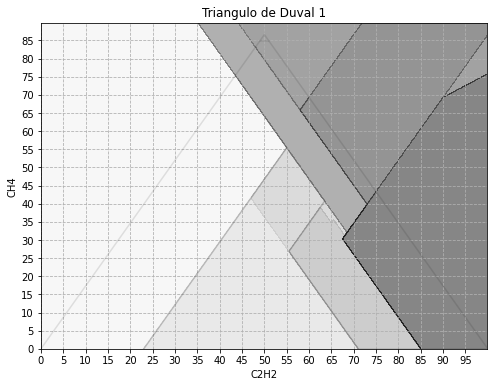

In [118]:
#Graficas del triangulo de Duval 1
plt.figure(figsize=(8, 6))
plt.contourf(TD1_xx, TD1_yy, TD1_z, 8, cmap = 'binary', alpha = 0.5)
plt.plot(region_PD_1[:, 0], region_PD_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_T1_1[:, 0], region_T1_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_T2_1[:, 0], region_T2_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_T3_1[:, 0], region_T3_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_D1_1[:, 0], region_D1_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_D2_1[:, 0], region_D2_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_DT_1[:, 0], region_DT_1[:, 1], 'k', alpha = alfa_TD1)
plt.grid(linestyle = '--', alpha = 1, axis = 'both')
plt.xlim(TD1_xx.min(), TD1_xx.max())
plt.ylim(TD1_yy.min(), TD1_yy.max())
plt.title('Triangulo de Duval 1')
plt.xlabel("C2H2")
plt.ylabel("CH4")
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 90, 5))
plt.show()

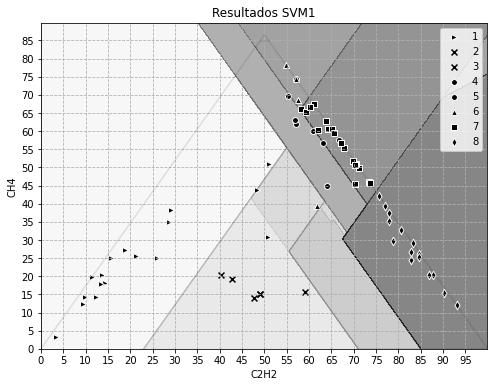

In [119]:
#Grafica de los resultados de acuerdo a SVM1
plt.figure(figsize=(8, 6))
plt.contourf(TD1_xx, TD1_yy, TD1_z, 8, cmap = 'binary', alpha = 0.5)
plt.plot(region_PD_1[:, 0], region_PD_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_T1_1[:, 0], region_T1_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_T2_1[:, 0], region_T2_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_T3_1[:, 0], region_T3_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_D1_1[:, 0], region_D1_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_D2_1[:, 0], region_D2_1[:, 1], 'k', alpha = alfa_TD1)
plt.plot(region_DT_1[:, 0], region_DT_1[:, 1], 'k', alpha = alfa_TD1)
plt.grid(linestyle = '--', alpha = 1, axis = 'both')
plt.xlim(TD1_xx.min(), TD1_xx.max())
plt.ylim(TD1_yy.min(), TD1_yy.max())
plt.title('Resultados SVM1')
plt.xlabel("C2H2")
plt.ylabel("CH4")
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 90, 5))

#Grafica de los puntos de validacion
for i in falla_marker_TD1:
  plt.scatter(TD1x_test[TD1y_test == i, 0], 
              TD1x_test[TD1y_test == i, 1],
              c = 'k', label = i, marker = falla_marker_TD1[i],
              s = 35, edgecolors = "w")
  plt.legend()
plt.show()

In [120]:
##Analisis de resultados con SVM1
lin_predTD1 = np.round(clf_1.predict(TD1x_test), decimals=3) #prediccion de SVM1
pre_lin_TD1 = np.round(clf_1.score(TD1x_test, TD1y_test), decimals=3) # %Score
cm_linTD1 = confusion_matrix(TD1y_test, lin_predTD1) # CM SVM1

  #Vectores de soporte
vs_TD1 = np.round(np.array(clf_1.support_vectors_), decimals=3)
vs_TD1_clase_0 = np.array(clf_1.predict(clf_1.support_vectors_))
vs_TD1_clase = (vs_TD1_clase_0).reshape(vs_TD1_clase_0.size,1)
mvs_TD1 = np.concatenate((vs_TD1, vs_TD1_clase), axis=1) #M de vs y clase

  #Resultados de prueba
res_test_td1_y = np.array(lin_predTD1).reshape(lin_predTD1.size,1)
res_test_td1 = np.concatenate((TD1x_test, res_test_td1_y), axis=1)

#RESULTADOS DE SVM1
print('Precisión SVM1:', pre_lin_TD1*100,'%')

Precisión SVM1: 91.4 %


In [121]:
print('Vectores de soporte para SVM1:', mvs_TD1, sep = '\n')

Vectores de soporte para SVM1:
[[43.5   71.88   1.   ]
 [52.995 55.434  1.   ]
 [21.99   1.732  1.   ]
 [25.99   1.732  2.   ]
 [46.995 38.114  2.   ]
 [68.     1.732  2.   ]
 [48.995 41.578  3.   ]
 [54.995 51.97   3.   ]
 [58.895 45.215  3.   ]
 [61.495 40.712  3.   ]
 [59.095 36.555  3.   ]
 [55.495 30.32   3.   ]
 [72.     1.732  4.   ]
 [69.1    6.755  4.   ]
 [66.2   11.778  4.   ]
 [57.5   26.847  4.   ]
 [58.5   28.579  4.   ]
 [62.5   35.507  4.   ]
 [82.     1.732  4.   ]
 [63.9   43.474  5.   ]
 [59.3   51.442  5.   ]
 [54.7   59.409  5.   ]
 [50.1   67.377  5.   ]
 [48.5   80.54   5.   ]
 [71.5   40.703  5.   ]
 [68.5   35.507  5.   ]
 [59.    69.282  6.   ]
 [58.    67.55   6.   ]
 [52.6   76.903  6.   ]
 [50.8   80.021  6.   ]
 [59.4   66.511  7.   ]
 [59.6   66.857  7.   ]
 [60.    67.55   7.   ]
 [72.7   42.782  7.   ]
 [72.5   42.435  7.   ]
 [67.1   51.788  7.   ]
 [64.4   56.465  7.   ]
 [61.7   61.141  7.   ]
 [59.    65.818  7.   ]
 [85.     3.464  8.   ]
 [81.9   

In [122]:
print('Matriz de confucion SVM1:', cm_linTD1, sep = '\n')

Matriz de confucion SVM1:
[[15  1  1  0  0  0  0]
 [ 0  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  6  1  2  0]
 [ 0  0  1  0  4  0  0]
 [ 0  0  0  0  0 18  0]
 [ 0  0  0  0  0  0 15]]


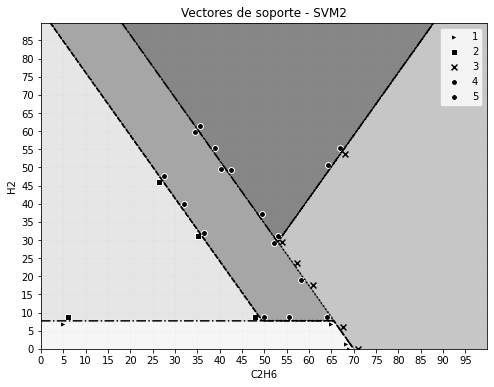

In [123]:
# Seleccion y procesamiento de datos para el entrenamiento de SVM2
TD4y_train_nan = datos[:,15] #Estado real del equipo
TD4y_train = TD4y_train_nan[~(np.isnan(TD4y_train_nan))]

TD4x_train_nan = datos[:, 12:14]    #Porcentaje de CH4 y H2
TD4x_train_nan = TD4x_train_nan[~(np.isnan(TD4x_train_nan))] #Depuracion
TD4x_train = np.array(TD4x_train_nan).reshape(int(TD4x_train_nan.size/2),2)

TD4_train_ones = np.ones(TD4y_train.size).reshape(TD4y_train.size,1)
TD4x_train_f = np.concatenate((TD4x_train, TD4_train_ones), axis=1)

#Matriz de CH4 Y H2 con coordenadas rectangulares para entrenamiento
TD4x_train = np.delete(TD4x_train_f @ np.transpose(A), 2, 1)

# Seleccion y procesamiento de datos para la validacion de SVM2
TD1y_nan = data_faulty[:,6]       #Estado real del equipo
TD1y_test = TD1y_nan[~(np.isnan(TD1y_nan))] #Depuracion de datos faltantes

MCH4_nanT4 = data_faulty[:,2:3]       #Matriz de CH4
MCH4T4 = MCH4_nanT4[~(np.isnan(MCH4_nanT4))] #Depuracion de datos faltantes
CH4T4 = MCH4T4.reshape(MCH4T4.size,1)

MH2_nanT4 = data_faulty[:,1:2]       #Matriz de H2
MH2T4 = MH2_nanT4[~(np.isnan(MH2_nanT4))] #Depuracion de datos faltantes
H2T4 = MH2T4.reshape(MH2T4.size,1)

MC2H6_nanT4 = data_faulty[:,3:4]       #Matriz de C2H6
MC2H6T4 = MC2H6_nanT4[~(np.isnan(MC2H6_nanT4))] #Depuracion de datos faltantes
C2H6T4 = MC2H6T4.reshape(MC2H6T4.size,1)

#Calculo de porcentajes para CH4, H2 y C2H6
pCH4T4  = np.round( (CH4T4  / (CH4T4+H2T4+C2H6T4) )*100, decimals=3)
pH2T4   = np.round( (H2T4   / (CH4T4+H2T4+C2H6T4) )*100, decimals=3)
pC2H6T4 = np.round( (C2H6T4 / (CH4T4+H2T4+C2H6T4) )*100, decimals=3)

#Separacion de fallas electricas y termicas
rest_TD1y4 = np.array(lin_predTD1).reshape(lin_predTD1.size,1)

#Combinacion de estados reales y resultados de SVM1
mb_rest_TD1y4 = np.any(rest_TD1y4==6, axis=1) | np.any(rest_TD1y4==7 , axis=1)
mb_real_TD1y4 = np.any(TDy_test==6, axis=1) | np.any(TDy_test==7 , axis=1)
rt_TD1_TD4 = mb_rest_TD1y4 | mb_real_TD1y4

#Matriz para datos de validacion de TD4
TD4y_test_nan = data_faulty[:,7]
TD4y_test_0 = TD4y_test_nan.reshape(int(TD4y_test_nan.size),1)
pMTD4 = np.concatenate((pCH4T4, pH2T4, TD4y_test_0), axis=1)

TD4 = np.array(pMTD4[rt_TD1_TD4, :])
TD4x_test_0 = np.delete(TD4, 2, 1)
pC2H6T4_ones = np.ones(TD4[:,0].size).reshape(TD4[:,0].size,1)
TD4x_test_f = np.concatenate((TD4x_test_0, pC2H6T4_ones), axis=1)

#Matriz de CH4 Y H2 con coordenadas rectangulares para validacion
TD4x_test = np.delete(TD4x_test_f @ np.transpose(A), 2, 1)
TD4y_test = np.delete(TD4, (0,1), 1).reshape(int(TD4x_test.size/2))

#Matriz para los puntos del TD4
TD4_p = np.array([
    [0, 0, 1],        #0-p1
    [0, 9, 1],        #1-p2
    [45, 9, 1],       #2-p3
    [61, 9, 1],       #3-p4
    [70, 0, 1],       #4-p5
    [0, 54, 1],       #5-p6
    [36, 34, 1],      #6-p7
    [36, 64, 1],      #7-p8
    [0, 100, 1],      #8-p9
    [100, 0, 1]])     #9-p10

# Transformacion de las cordenadas TD4 en rectangulares
TD4_v = TD4_p @ np.transpose(A)

# Se define las regiones en funcion de los puntos de cada area del TD4
region_PD_4 = TD4_v[[0, 1, 3, 4], :]
region_T1_4 = TD4_v[[1, 2, 5, 1], :]
region_T2_4 = TD4_v[[2, 3, 6, 7, 8, 5, 2], :]
region_T3_4 = TD4_v[[4, 6, 7, 9], :]

#Parametros de regulacion para SVM1
C_4 = 1 #Regulacion 1 - valor 1
clf_4 = svm.SVC(kernel='linear', C = C_4, decision_function_shape='ovo')
modelo_SVM2 = clf_4.fit(TD4x_train,TD4y_train)

h4 = 0.1 #Regulacion 2 - valor 0.1
TD4_xx, TD4_yy = np.meshgrid(np.arange(0, 100, h), 
                             np.arange(0, 90, h))
TD4_z = clf_4.predict(np.c_[TD4_xx.ravel(), 
                            TD4_yy.ravel()]).reshape(TD4_xx.shape)

#Grafica Vectores de soporte SVM2 y areas
alfa_TD4 = 0.1
plt.figure(figsize=(8, 6))
plt.contourf(TD4_xx, TD4_yy, TD4_z, 8, cmap = 'binary', alpha = 0.5)
plt.grid(linestyle = '--', alpha = 0.1, axis = 'both')
plt.xlim(TD4_xx.min(), TD4_xx.max())
plt.ylim(TD4_yy.min(), TD4_yy.max())
plt.title('Vectores de soporte - SVM2')
plt.xlabel("C2H6")
plt.ylabel("H2")
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 90, 5))

  #Grafica de los limites entre vectores de soporte
plt.contour(TD4_xx, TD4_yy, TD4_z,
            linestyles = ['-.','--',':','-.','--',':','--'],
            colors = 'k', 
            levels=[1,2,3,4,5])

#Diccionario para los simbolos de acuerdo a la falla
marker_TD4 = ['>', 's', 'x', 'o', 'o']
falla_TD4 = [1,2,3,4,5]
falla_marker_TD4 = dict(zip(falla_TD4, marker_TD4))

  #Grafica de los vectores de soporte
vs_TD4_clase_0 = np.array(clf_4.predict(clf_4.support_vectors_))

for i in falla_marker_TD4:
  plt.scatter(clf_4.support_vectors_[vs_TD4_clase_0 == i, 0],
              clf_4.support_vectors_[vs_TD4_clase_0 == i, 1], 
              c = 'k', label = i, marker = falla_marker_TD4[i],
              s = 35, edgecolors = "w", zorder = 1)
  plt.legend()
plt.show()

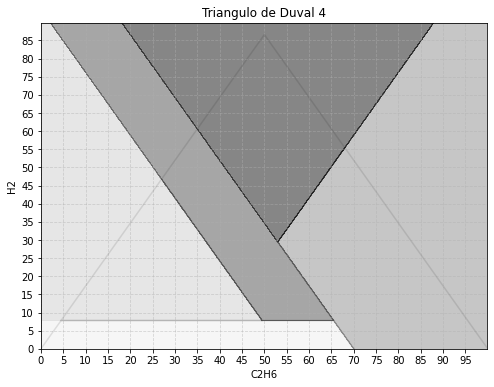

In [124]:
#Grafica del triangulo de Duval 4 y contorno
plt.figure(figsize=(8, 6))
plt.contourf(TD4_xx, TD4_yy, TD4_z, 8, cmap = 'binary', alpha = 0.5)
plt.plot(region_PD_4[:, 0], region_PD_4[:, 1], 'k', alpha = alfa_TD4)
plt.plot(region_T1_4[:, 0], region_T1_4[:, 1], 'k', alpha = alfa_TD4)
plt.plot(region_T2_4[:, 0], region_T2_4[:, 1], 'k', alpha = alfa_TD4)
plt.plot(region_T3_4[:, 0], region_T3_4[:, 1], 'k', alpha = alfa_TD4)
plt.grid(linestyle = '--', alpha = 0.5, axis = 'both')
plt.xlim(TD4_xx.min(), TD4_xx.max())
plt.ylim(TD4_yy.min(), TD4_yy.max())
plt.title('Triangulo de Duval 4')
plt.xlabel("C2H6")
plt.ylabel("H2")
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 90, 5))
plt.show()

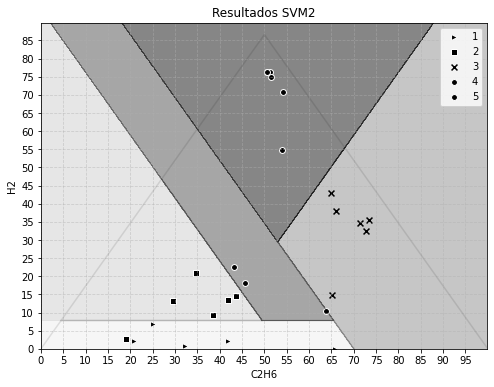

In [125]:
#Grafica de los resultados de acuerdo a SVM2
plt.figure(figsize=(8, 6))
plt.contourf(TD4_xx, TD4_yy, TD4_z, 8, cmap = 'binary', alpha = 0.5)
plt.plot(region_PD_4[:, 0], region_PD_4[:, 1], 'k', alpha = alfa_TD4)
plt.plot(region_T1_4[:, 0], region_T1_4[:, 1], 'k', alpha = alfa_TD4)
plt.plot(region_T2_4[:, 0], region_T2_4[:, 1], 'k', alpha = alfa_TD4)
plt.plot(region_T3_4[:, 0], region_T3_4[:, 1], 'k', alpha = alfa_TD4)
plt.grid(linestyle = '--', alpha = 0.5, axis = 'both')
plt.xlim(TD4_xx.min(), TD4_xx.max())
plt.ylim(TD4_yy.min(), TD4_yy.max())
plt.title('Resultados SVM2')
plt.xlabel("C2H6")
plt.ylabel("H2")
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 90, 5))

#Grafica de los puntos de validacion
for i in falla_marker_TD4:
  plt.scatter(TD4x_test[TD4y_test == i, 0], 
              TD4x_test[TD4y_test == i, 1],
              c = 'k', label = i, marker = falla_marker_TD4[i],
              s = 35, edgecolors = "w")
  plt.legend()
plt.show()

In [126]:
##Analisis de resultados con SVM2
lin_predTD4 = np.round(clf_4.predict(TD4x_test), decimals=3) #prediccion de SVM2
pre_lin_TD4 = np.round(clf_4.score(TD4x_test, TD4y_test), decimals=3) # %Score
cm_linTD4 = confusion_matrix(TD4y_test, lin_predTD4) # CM SVM2

  #Vectores de soporte
vs_TD4 = np.round(np.array(clf_4.support_vectors_), decimals=3)
vs_TD4_clase_0 = np.array(clf_4.predict(clf_4.support_vectors_))
vs_TD4_clase = (vs_TD4_clase_0).reshape(vs_TD4_clase_0.size,1)
mvs_TD4 = np.concatenate((vs_TD4, vs_TD4_clase), axis=1) #M de vs y clase

  #Resultados de prueba
res_test_td4_y = np.array(lin_predTD4).reshape(lin_predTD4.size,1)
res_test_td4 = np.concatenate((TD4x_test, res_test_td4_y), axis=1)

#RESULTADOS DE SVM2
print('Precisión SVM2:', pre_lin_TD4*100,'%')

Precisión SVM2: 96.2 %


In [127]:
print('Vectores de soporte para SVM2:', mvs_TD4, sep = '\n')

Vectores de soporte para SVM2:
[[ 5.     6.928  1.   ]
 [65.     6.928  1.   ]
 [68.2    1.386  1.   ]
 [69.     0.     1.   ]
 [ 6.     8.66   2.   ]
 [48.     8.66   2.   ]
 [35.1   31.004  2.   ]
 [26.5   45.899  2.   ]
 [71.     0.     3.   ]
 [67.6    5.889  3.   ]
 [60.8   17.667  3.   ]
 [57.4   23.556  3.   ]
 [54.    29.445  3.   ]
 [68.    53.694  3.   ]
 [27.5   47.631  4.   ]
 [32.    39.837  4.   ]
 [36.5   32.043  4.   ]
 [50.     8.66   4.   ]
 [55.6    8.66   4.   ]
 [64.     8.66   4.   ]
 [58.1   18.879  4.   ]
 [52.2   29.098  4.   ]
 [40.4   49.537  4.   ]
 [34.5   59.756  4.   ]
 [35.5   61.488  5.   ]
 [39.    55.426  5.   ]
 [42.5   49.363  5.   ]
 [49.5   37.239  5.   ]
 [53.    31.177  5.   ]
 [64.2   50.576  5.   ]
 [67.    55.426  5.   ]]


In [128]:
print('Matriz de confucion SVM2:', cm_linTD4, sep = '\n')

Matriz de confucion SVM2:
[[5 0 0 0 0]
 [1 5 0 0 0]
 [0 0 6 0 0]
 [0 0 0 3 0]
 [0 0 0 0 6]]


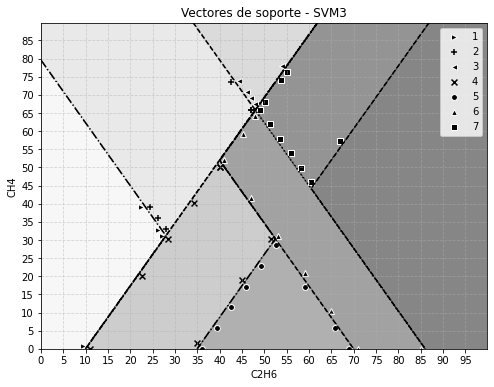

In [129]:
# Seleccion y procesamiento de datos para el entrenamiento de SVM3
TD5y_train_nan = datos[:,19] #Estado real del equipo
TD5y_train = TD5y_train_nan[~(np.isnan(TD5y_train_nan))]

TD5x_train_nan = datos[:, 16:18]    #Porcentaje de C2H4 y CH4
TD5x_train_nan = TD5x_train_nan[~(np.isnan(TD5x_train_nan))] #Depuracion
TD5x_train = np.array(TD5x_train_nan).reshape(int(TD5x_train_nan.size/2),2)

TD5_train_ones = np.ones(TD5y_train.size).reshape(TD5y_train.size,1)
TD5x_train_f = np.concatenate((TD5x_train, TD5_train_ones), axis=1)

#Matriz de C2H4 Y  CH4 con coordenadas rectangulares para entrenamiento
TD5x_train = np.delete(TD5x_train_f @ np.transpose(A), 2, 1)

# Seleccion y procesamiento de datos para la validacion de SVM3
TD1y_nan = data_faulty[:,6]       #Estado real del equipo
TD1y_test = TD1y_nan[~(np.isnan(TD1y_nan))] #Depuracion de datos faltantes

MC2H4_nanT5 = data_faulty[:,4:5]       #Matriz de C2H4
MC2H4T5 = MC2H4_nanT5[~(np.isnan(MC2H4_nanT5))] #Depuracion de datos faltantes
C2H4T5 = MC2H4T5.reshape(MC2H4T5.size,1)

MCH4_nanT5 = data_faulty[:,2:3]       #Matriz de CH4
MCH4T5 = MCH4_nanT5[~(np.isnan(MCH4_nanT5))] #Depuracion de datos faltantes
CH4T5 = MCH4T5.reshape(MCH4T5.size,1)

MC2H6_nanT5 = data_faulty[:,3:4]       #Matriz de C2H6
MC2H6T5 = MC2H6_nanT5[~(np.isnan(MC2H6_nanT5))] #Depuracion de datos faltantes
C2H6T5 = MC2H6T5.reshape(MC2H6T5.size,1)

#Calculo de porcentajes para C2H4, CH4 y C2H6
pC2H4T5  = np.round( (C2H4T5 / (C2H4T5+CH4T5+C2H6T5) )*100, decimals=3)
pCH4T5   = np.round( (CH4T5  / (C2H4T5+CH4T5+C2H6T5) )*100, decimals=3)
pC2H6T5  = np.round( (C2H6T5 / (C2H4T5+CH4T5+C2H6T5) )*100, decimals=3)

#Separacion de fallas electricas y termicas
rest_TD1y5 = np.array(lin_predTD1).reshape(lin_predTD1.size,1)

#Combinacion de estados reales y resultados de SVM3
mb_rest_TD1y5 = np.any(rest_TD1y5==7, axis=1) | np.any(rest_TD1y5==8 , axis=1)
mb_real_TD1y5 = np.any(TDy_test==7, axis=1) | np.any(TDy_test==8 , axis=1)
rt_TD1_TD5 = mb_rest_TD1y5 | mb_real_TD1y5

#Matriz para datos de validacion de TD5
TD5y_test_nan = data_faulty[:,8]
TD5y_test_0 = TD5y_test_nan.reshape(int(TD5y_test_nan.size),1)
pMTD5 = np.concatenate((pC2H4T5, pCH4T5, TD5y_test_0), axis=1)

TD5 = np.array(pMTD5[rt_TD1_TD5, :])
TD5x_test_0 = np.delete(TD5, 2, 1)
pC2H6T5_ones = np.ones(TD5[:,0].size).reshape(TD5[:,0].size,1)
TD5x_test_f = np.concatenate((TD5x_test_0, pC2H6T5_ones), axis=1)

#Matriz de C2H4 Y CH4 con coordenadas rectangulares para validacion
TD5x_test = np.delete(TD5x_test_f @ np.transpose(A), 2, 1)
TD5y_test = np.delete(TD5, (0,1), 1).reshape(int(TD5x_test.size/2))

#Matriz para los puntos del TD5
TD5_p = np.array([
    [0, 0, 1],          #0-p1
    [10, 0, 1],        #1-p2
    [0, 46, 1],        #2-p3
    [10, 36, 1],         #3-p4
    [0, 86, 1],         #4-p5
    [10, 76, 1],         #5-p6
    [10, 60, 1],         #6-p7
    [10, 90, 1],         #7-p8
    [0, 100, 1],        #8-p9
    [35, 51, 1],        #9-p10
    [35, 65, 1],        #10-p11
    [100, 0, 1],        #11-p12
    [86, 0, 1],        #12-p13
    [70, 0, 1],        #13-p14
    [35, 35, 1],        #14-p15
    [35, 0, 1]])        #15-p16

# Transformacion de las cordenadas TD5 en rectangulares
TD5_v = TD5_p @ np.transpose(A)

# Se define las regiones en funcion de los puntos de cada area del TD5
region_PD_5 = TD5_v[[0, 1, 3, 2, 0], :]
region_T1_5 = TD5_v[[2, 3, 5, 4, 2], :]
region_T2_5 = TD5_v[[4, 5, 7, 8, 4], :]
region_T3_5 = TD5_v[[1, 6, 14, 15, 1], :]
region_D1_5 = TD5_v[[15, 14, 13, 15], :]
region_D2_5 = TD5_v[[13, 6, 5, 12, 13], :]
region_DT_5 = TD5_v[[7, 5, 9, 10, 7], :]
region_D3_5 = TD5_v[[10, 9, 12, 11, 10], :]

#Parametros de regulacion para SVM3
C_5 = 1 #Regulacion 1 - valor 1
clf_5 = svm.SVC(kernel='linear', C = C_5, decision_function_shape='ovo')
modelo_SVM3 = clf_5.fit(TD5x_train,TD5y_train)

h5 = 0.1 #Regulacion 2 - valor 0.1
TD5_xx, TD5_yy = np.meshgrid(np.arange(0, 100, h), 
                             np.arange(0, 90, h))
TD5_z = clf_5.predict(np.c_[TD5_xx.ravel(), 
                            TD5_yy.ravel()]).reshape(TD5_xx.shape)

#Grafica Vectores de soporte SVM3 y areas
alfa_TD5 = 0.1
plt.figure(figsize=(8, 6))
plt.contourf(TD5_xx, TD5_yy, TD5_z, 8, cmap = 'binary', alpha = 0.5)
plt.grid(linestyle = '--', alpha = 0.5, axis = 'both')
plt.xlim(TD5_xx.min(), TD5_xx.max())
plt.ylim(TD5_yy.min(), TD5_yy.max())
plt.title('Vectores de soporte - SVM3')
plt.xlabel("C2H6")
plt.ylabel("CH4")
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 90, 5))

  #Grafica de los limites entre vectores de soporte
plt.contour(TD5_xx, TD5_yy, TD5_z,
            linestyles = ['-.','--',':','-.','--',':','--'],
            colors = 'k', 
            levels = [1,2,3,4,5,6,7])

#Diccionario para los simbolos de acuerdo a la falla
marker_TD5 = ['>', '+', '<', 'x', 'o', '^', 's', 'd']
falla_TD5 = [1,2,3,4,5,6,7]
falla_marker_TD5 = dict(zip(falla_TD5, marker_TD5))

  #Grafica de los vectores de soporte
vs_TD5_clase_0 = np.array(clf_5.predict(clf_5.support_vectors_))

for i in falla_marker_TD5:
  plt.scatter(clf_5.support_vectors_[vs_TD5_clase_0 == i, 0],
              clf_5.support_vectors_[vs_TD5_clase_0 == i, 1], 
              c = 'k', label = i, marker = falla_marker_TD5[i],
              s = 35, edgecolors = "w", zorder = 1)
  plt.legend()
plt.show()

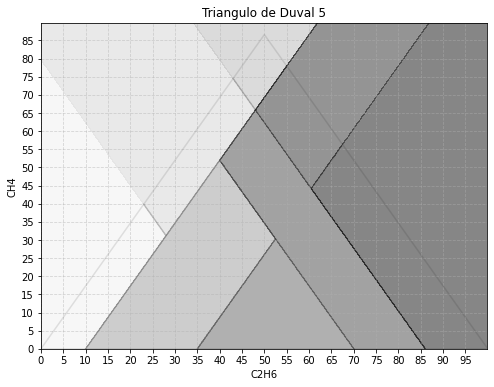

In [130]:
#Grafica del triangulo de Duval 5
plt.figure(figsize=(8, 6))
plt.contourf(TD5_xx, TD5_yy, TD5_z, 8, cmap = 'binary', alpha = 0.5)
plt.plot(region_PD_5[:, 0], region_PD_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_T1_5[:, 0], region_T1_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_T2_5[:, 0], region_T2_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_T3_5[:, 0], region_T3_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_D1_5[:, 0], region_D1_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_D2_5[:, 0], region_D2_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_DT_5[:, 0], region_DT_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_D3_5[:, 0], region_D3_5[:, 1], 'k', alpha = alfa_TD5)
plt.grid(linestyle = '--', alpha = 0.5, axis = 'both')
plt.xlim(TD5_xx.min(), TD5_xx.max())
plt.ylim(TD5_yy.min(), TD5_yy.max())
plt.title('Triangulo de Duval 5')
plt.xlabel("C2H6")
plt.ylabel("CH4")
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 90, 5))
plt.show()

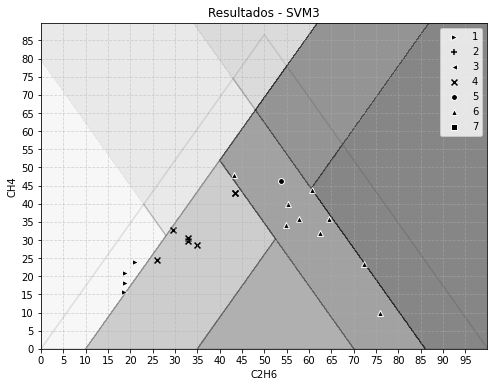

In [131]:
#Grafica de los resultados de acuerdo a SVM3
plt.figure(figsize=(8, 6))
plt.contourf(TD5_xx, TD5_yy, TD5_z, 8, cmap = 'binary', alpha = 0.5)
plt.plot(region_PD_5[:, 0], region_PD_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_T1_5[:, 0], region_T1_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_T2_5[:, 0], region_T2_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_T3_5[:, 0], region_T3_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_D1_5[:, 0], region_D1_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_D2_5[:, 0], region_D2_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_DT_5[:, 0], region_DT_5[:, 1], 'k', alpha = alfa_TD5)
plt.plot(region_D3_5[:, 0], region_D3_5[:, 1], 'k', alpha = alfa_TD5)
plt.grid(linestyle = '--', alpha = 0.5, axis = 'both')
plt.xlim(TD5_xx.min(), TD5_xx.max())
plt.ylim(TD5_yy.min(), TD5_yy.max())
plt.title('Resultados - SVM3')
plt.xlabel("C2H6")
plt.ylabel("CH4")
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 90, 5))

#Grafica de los puntos de validacion
for i in falla_marker_TD5:
  plt.scatter(TD5x_test[TD5y_test == i, 0], 
              TD5x_test[TD5y_test == i, 1],
              c = 'k', label = i, marker = falla_marker_TD5[i],
              s = 35, edgecolors = "w")
  plt.legend()
plt.show()

In [132]:
##Analisis de resultados con SVM3
lin_predTD5 = np.round(clf_5.predict(TD5x_test), decimals=3) #prediccion de SVM3
pre_lin_TD5 = np.round(clf_5.score(TD5x_test, TD5y_test), decimals=3) # %Score
cm_linTD5 = confusion_matrix(TD5y_test, lin_predTD5) # CM SVM3

  #Vectores de soporte
vs_TD5 = np.round(np.array(clf_5.support_vectors_), decimals=3)
vs_TD5_clase_0 = np.array(clf_5.predict(clf_5.support_vectors_))
vs_TD5_clase = (vs_TD5_clase_0).reshape(vs_TD5_clase_0.size,1)
mvs_TD5 = np.concatenate((vs_TD5, vs_TD5_clase), axis=1) #M de vs y clase

  #Resultados de prueba
res_test_td5_y = np.array(lin_predTD5).reshape(lin_predTD5.size,1)
res_test_td5 = np.concatenate((TD5x_test, res_test_td5_y), axis=1)

#RESULTADOS DE SVM3
print('Precisión SVM3:', pre_lin_TD5*100,'%')

Precisión SVM3: 94.3 %


In [133]:
print('Vectores de soporte para SVM3:', mvs_TD5, sep = '\n')

Vectores de soporte para SVM3:
[[ 9.5    0.866  1.   ]
 [27.    31.177  1.   ]
 [26.1   32.736  1.   ]
 [22.5   38.971  1.   ]
 [24.4   39.144  2.   ]
 [26.2   36.027  2.   ]
 [28.    32.909  2.   ]
 [47.    65.818  2.   ]
 [47.    65.818  2.   ]
 [42.5   73.612  2.   ]
 [44.4   73.785  3.   ]
 [46.2   70.668  3.   ]
 [47.1   69.109  3.   ]
 [48.    67.55   3.   ]
 [54.    77.942  3.   ]
 [11.     0.     4.   ]
 [22.6   20.092  4.   ]
 [28.4   30.138  4.   ]
 [34.2   40.184  4.   ]
 [40.    50.229  4.   ]
 [40.    50.229  4.   ]
 [51.5   30.311  4.   ]
 [44.9   18.879  4.   ]
 [35.     1.732  4.   ]
 [36.     0.     5.   ]
 [39.3    5.716  5.   ]
 [42.6   11.432  5.   ]
 [45.9   17.147  5.   ]
 [49.2   22.863  5.   ]
 [52.5   28.579  5.   ]
 [59.1   17.147  5.   ]
 [65.7    5.716  5.   ]
 [69.     0.     5.   ]
 [71.     0.     6.   ]
 [65.    10.392  6.   ]
 [59.    20.785  6.   ]
 [53.    31.177  6.   ]
 [47.    41.569  6.   ]
 [41.    51.962  6.   ]
 [45.2   59.236  6.   ]
 [48.    

In [134]:
print('Matriz de confucion SVM3:', cm_linTD5, sep = '\n')

Matriz de confucion SVM3:
[[ 4  0  0  0  0]
 [ 0  7  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0  0  8  1]
 [ 0  0  0  0 14]]
